# Определение возраста покупателя по фотографии

### Введение

Супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; контролировать добросовестность кассиров при продаже алкоголя.  

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

### 1. Исследовательский анализ данных

In [1]:
# импорт функций и библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# загрузка датасета с именами файлов изображений и метками возраста
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# общий вид датасета с метками
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков нет, тип данных корректен.

In [5]:
# проверка на наличие дупликатов
labels.duplicated().sum()

0

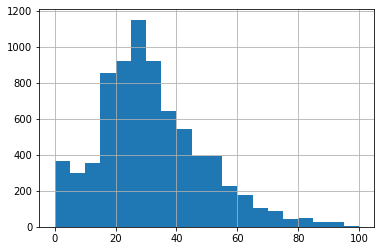

In [6]:
# график распределения возраста в выборке
labels['real_age'].hist(bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])

Интерпретация графика будет дана в конце раздела.

In [7]:
# инициализация класса ImageDataGenerator для формирования батчей с изображениями
train_datagen = ImageDataGenerator(rescale=1./255)
# динамическое извлечение данных
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345) 

Found 7591 validated image filenames.


In [8]:
# создание пар "фотография - метка возраста"
features, target = next(train_gen_flow)

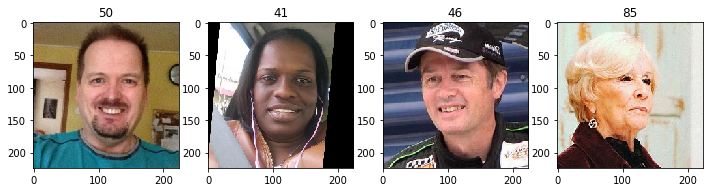

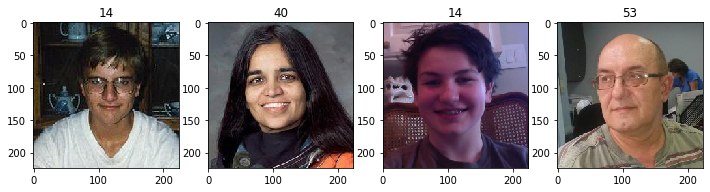

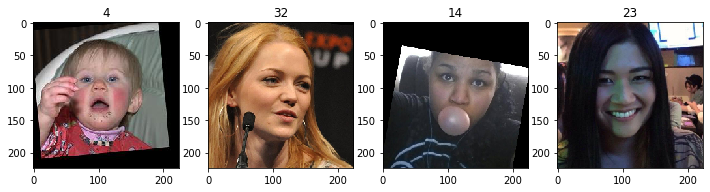

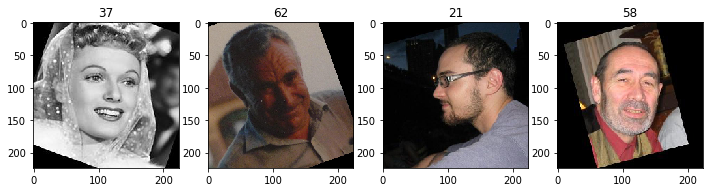

In [9]:
# вывод на экран нескольких фотографий с меткой возраста
for i in range(4):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for j in range(4):
        axes[j].imshow(features[4 * i + j])
        axes[j].set_title(target[4 * i + j])

### Вывод по исследовательскому анализу данных


Выборка содержит 7591 фотографию с меткой возраста. Дубликатов, пропусков данных не обнаружено.

По гистограмме распределения возраста видно, что наибольшую часть составляют покупатели в
возрасте от 15 до 45 лет.  
Заметна значительная доля "клиентов" в возрасте до 10 лет. Очевидно, это
дети, пришедшие с родителями.  
Относительно небольшое количество фотографий покупателей возраста 65+ позволяет предположить, что модель будет определять возраст пожилых людей менее точно, чем возраст молодых клиентов и людей среднего возраста.

Замечания по самим картинкам:

1. В датасете есть как черно-белые, так и цветные фотографии. Для корректного обучения сети лучше привести фото к серой карте цветов (cmap='gray').
2. Некоторые фото достаточно старые и зашумлены - можно было бы попробовать повысить контрастность этих фото для более четкого выделения контуров разных частей распознаваемых объектов.
3. Также некоторые фото сделаны при плохом освещении. Возможно, можно было бы привести их (или все фото) к какому-нибудь определенному уровню экспозиции (если корректировать все фото, то для темных фото экспозицию повысить, для светлых - понизить).
4. На фотографиях различные размеры лиц, можно попробовать масштабировать фото для приведения к одному размеру лица (можно было бы использовать фильтрацию контуров и по ним масштабировать - помогла бы библиотека OpenCV).
5. Так как фото людей старше 60 достаточно мало, можно было бы выполнить геометрические аугментации(повороты, зеркальные отражения по различным осям и т.д.) для увеличения числа обучаемых объектов для лучшего распознавания людей старше 60.

### 2. Обучение модели

Код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# импорт функций и библиотек
import pandas as pd  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.applications.resnet import ResNet50  
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.optimizers import Adam

# функция динамического извлечения данных обучающей выборки
def load_train(path):
    
    # чтение датасета с именами файлов изображений и метками возраста
    labels = pd.read_csv(path + 'labels.csv')
    
    # инициализация класса ImageDataGenerator для формирования батчей с изображениями
    train_datagen = ImageDataGenerator(
        validation_split=0.25, # валидация содержит 25% случайных объектов
        horizontal_flip=True, # аугментация методом горизонтального отражения
        rescale=1./255) # деление значения яркости на 255
    
    # динамическое извлечение данных обучающей выборки
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels, # датасет с метками
        directory=path + 'final_files/', # путь к папке с изображениями
        x_col='file_name', # признаки
        y_col='real_age', # целевой признак
        target_size=(224, 224), # размер, к которому будут приводиться изображения в батче
        batch_size=16, # количество изображений в батче
        class_mode='raw', # тип выдачи метки классов - "raw", потому что это задача регрессии
        subset='training', # это загрузчик для обучающей выборки
        seed=12345) # random state

    return train_gen_flow

# функция динамического извлечения данных тестовой выборки
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

# функция создания модели - применим архитектуру ResNet
def create_model(input_shape):
    
    # создание основы модели
    backbone = ResNet50(weights='imagenet', # инициализация весов на базе датасета ImageNet
                        input_shape=input_shape, # размер входного изображения
                        include_top=False) # исключаем слои GlobalAveragePooling2D и Dense, 
                                           # т.к. сеть предобучена на датасете ImageNet,
                                           # а будет применяться к другому, нашему датасету.

    model = Sequential() # инициализация модели класса Sequential - слои идут последовательно 
    model.add(backbone) # создание слоев ResNet (основы модели)
    model.add(GlobalAveragePooling2D()) # добавление слоя, который усредняет информацию по всему изображению
    model.add(Dense(1, activation='relu')) # добавление полносвязного слоя;  
                                           # в выходном слое один нейрон, т.к. решается задача регрессии;
                                           # тип активации Rectified Linear Unit (выпрямленное линейное преобразование) 
                                           # приводит к нулю всё, что меньше 0, и оставляет положительные значения.

    optimizer = Adam(lr=0.0005) # в качестве алгоритма обучения применим алгоритм Adam со скоростью обучения 0.0005 
    model.compile(optimizer=optimizer,
                  loss='mse', # можно было выбрать и MAE, 
                              # но зачастую нейронные сети с функцией потерь MSE обучаются быстрее
                  metrics=['mae']) # в качестве метрики возьмем Mean Absolute Error

    return model

# функция обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, # содержит features_train и target_train
              validation_data=test_data, # валидационной выборкой будет тестовая
              batch_size=batch_size, # размер батча - количество образцов на обновление градиента
              epochs=epochs, # количество эпох, т.е. проходов полного датасета (всех батчей) через модель
              steps_per_epoch=steps_per_epoch, # количество батчей перед объявлением одной эпохи законченной
              validation_steps=validation_steps, # количество батчей для проверки при завершении эпохи
              verbose=2) # вывод на экран одной строки в эпоху

    return model

```

```

# < результат вывода на экран >

2020-08-01 19:23:31.573511: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-08-01 19:23:32.020463: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2020-08-01 19:23:48.656037: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-08-01 19:23:49.326182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-08-01 19:23:49.326265: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-08-01 19:23:49.326303: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-08-01 19:23:49.569730: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-08-01 19:23:49.645233: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-08-01 19:23:50.260193: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-08-01 19:23:50.338344: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-08-01 19:23:50.338437: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-08-01 19:23:50.342174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-08-01 19:23:50.342651: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-08-01 19:23:50.505986: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2020-08-01 19:23:50.513039: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4c2ef10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-08-01 19:23:50.513070: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-08-01 19:23:50.916580: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4cb4f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2020-08-01 19:23:50.916650: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2020-08-01 19:23:50.918941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-08-01 19:23:50.919057: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-08-01 19:23:50.919086: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-08-01 19:23:50.919109: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-08-01 19:23:50.919152: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-08-01 19:23:50.919165: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-08-01 19:23:50.919177: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-08-01 19:23:50.919187: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-08-01 19:23:50.923165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-08-01 19:23:50.943823: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-08-01 19:23:56.976283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-08-01 19:23:56.976334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2020-08-01 19:23:56.976344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2020-08-01 19:23:56.994264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2020-08-01 19:24:35.564951: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-08-01 19:24:39.722250: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 112s - loss: 226.4537 - mae: 11.3905 - val_loss: 784.6233 - val_mae: 23.1063
Epoch 2/20
356/356 - 44s - loss: 139.2543 - mae: 9.0267 - val_loss: 295.9069 - val_mae: 12.9016
Epoch 3/20
356/356 - 43s - loss: 118.4835 - mae: 8.3168 - val_loss: 129.3753 - val_mae: 8.6956
Epoch 4/20
356/356 - 43s - loss: 98.1951 - mae: 7.4758 - val_loss: 111.6861 - val_mae: 8.1363
Epoch 5/20
356/356 - 43s - loss: 85.7666 - mae: 7.0387 - val_loss: 150.0893 - val_mae: 9.1832
Epoch 6/20
356/356 - 42s - loss: 71.0652 - mae: 6.4386 - val_loss: 118.1678 - val_mae: 7.9469
Epoch 7/20
356/356 - 43s - loss: 61.4815 - mae: 6.0198 - val_loss: 107.1053 - val_mae: 7.6687
Epoch 8/20
356/356 - 43s - loss: 53.9959 - mae: 5.6894 - val_loss: 129.1930 - val_mae: 8.4635
Epoch 9/20
356/356 - 43s - loss: 43.9439 - mae: 5.1377 - val_loss: 102.6490 - val_mae: 7.5296
Epoch 10/20
356/356 - 44s - loss: 37.2398 - mae: 4.7110 - val_loss: 117.4723 - val_mae: 8.5026
Epoch 11/20
356/356 - 43s - loss: 33.4555 - mae: 4.4425 - val_loss: 112.0311 - val_mae: 8.1820
Epoch 12/20
356/356 - 42s - loss: 30.9492 - mae: 4.2328 - val_loss: 115.6807 - val_mae: 8.0475
Epoch 13/20
356/356 - 43s - loss: 28.4375 - mae: 4.1624 - val_loss: 92.4594 - val_mae: 7.3572
Epoch 14/20
356/356 - 43s - loss: 28.3929 - mae: 4.0778 - val_loss: 106.1800 - val_mae: 7.7366
Epoch 15/20
356/356 - 42s - loss: 24.1844 - mae: 3.7520 - val_loss: 101.8265 - val_mae: 7.4497
Epoch 16/20
356/356 - 42s - loss: 21.1685 - mae: 3.5468 - val_loss: 86.2916 - val_mae: 7.1253
Epoch 17/20
356/356 - 44s - loss: 20.0556 - mae: 3.4418 - val_loss: 122.1815 - val_mae: 8.2076
Epoch 18/20
356/356 - 43s - loss: 17.8596 - mae: 3.2803 - val_loss: 100.2634 - val_mae: 7.9344
Epoch 19/20
356/356 - 43s - loss: 17.0353 - mae: 3.1895 - val_loss: 80.3803 - val_mae: 6.6432
Epoch 20/20
356/356 - 42s - loss: 17.3538 - mae: 3.2058 - val_loss: 89.1627 - val_mae: 6.9651
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 89.1627 - mae: 6.9651
Test MAE: 6.9651

```

### 3. Анализ обученной модели

В этой работе решалась задача регрессии - определение числового значения возраста человека по фотографии его лица.  

Модель создана на основе архитектуры ResNet (Residual Network, остаточная сеть) особенностью которой является применение skip-connections, свёртков небольшого размера и bottleneck-блоков.

Модель обучена на выборке, содержащей 7591 фотографию с меткой возраста. Т.к. выборка содержит относительно небольшое количество образцов фотографий лиц пожилого возраста (65+), то можно ожидать повышенную погрешность определения возраста лиц этой категории. Однако, исходя из целей задачи, это не является критическим недостатком модели.

В качестве метрики качества использовали МАЕ (Мean Аbsolute Еrror, среднее абсолютное отклонение).  
Проверка на тестовой выборке показала, что модель будет определять возраст с точностью +/-7 лет. Исходя из целей задачи - предложение потенциально интересных товаров, контроль возраста при продаже алкоголя - результат удовлетворителен для работы с покупателями возраста 26 лет и старше, но модель не рекомендуется применять при работе с более молодыми клиентами (согласно законодательству РФ продажа алкоголя запрещена лицам младше 18 лет).